Hola &#x1F600;

Soy **Hesus Garcia**  como "Jesús" pero con H. Sé que puede ser confuso al principio, pero una vez que lo recuerdes, ¡nunca lo olvidarás! &#x1F31D;	. Como revisor de código de Practicum, estoy emocionado de examinar tus proyectos y ayudarte a mejorar tus habilidades en programación. si has cometido algún error, no te preocupes, pues ¡estoy aquí para ayudarte a corregirlo y hacer que tu código brille! &#x1F31F;. Si encuentro algún detalle en tu código, te lo señalaré para que lo corrijas, ya que mi objetivo es ayudarte a prepararte para un ambiente de trabajo real, donde el líder de tu equipo actuaría de la misma manera. Si no puedes solucionar el problema, te proporcionaré más información en la próxima oportunidad. Cuando encuentres un comentario,  **por favor, no los muevas, no los modifiques ni los borres**. 

Revisaré cuidadosamente todas las implementaciones que has realizado para cumplir con los requisitos y te proporcionaré mis comentarios de la siguiente manera:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

</br>

**¡Empecemos!**  &#x1F680;

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Me parece genial que hayas incluido una tabla de contenidos en tu documento, esto facilitará la navegación y comprensión de los temas que estás tratando. ¡Sigue así!</div>
</div>


## Preparación

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
# Cargar los datos
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])  
data.set_index('datetime', inplace=True)  

In [3]:
# Remuestrear los datos por hora
data_hourly = data.resample('H').sum()

In [4]:
# Verificar valores nulos e información básica
print(data_hourly.info())
print(data_hourly.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


Es posible observar que, en promedio, hay 84 pedidos de taxis cada hora durante el periodo analizado. Adicionalmente, es posible observar variabilidad moderada en la distribución de los datos. Destaca que la cantidad de pedidos de taxis cada hora puede variar desde 0 hasta 462.

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a> Excelente trabajo preparando los datos, especialmente con la resampleación por hora y la verificación de valores nulos. Sin embargo, podrías complementar con un análisis de autocorrelación o estacionalidad para determinar si existen patrones repetitivos en el tiempo, lo que puede mejorar el modelo predictivo. </div>

## Análisis

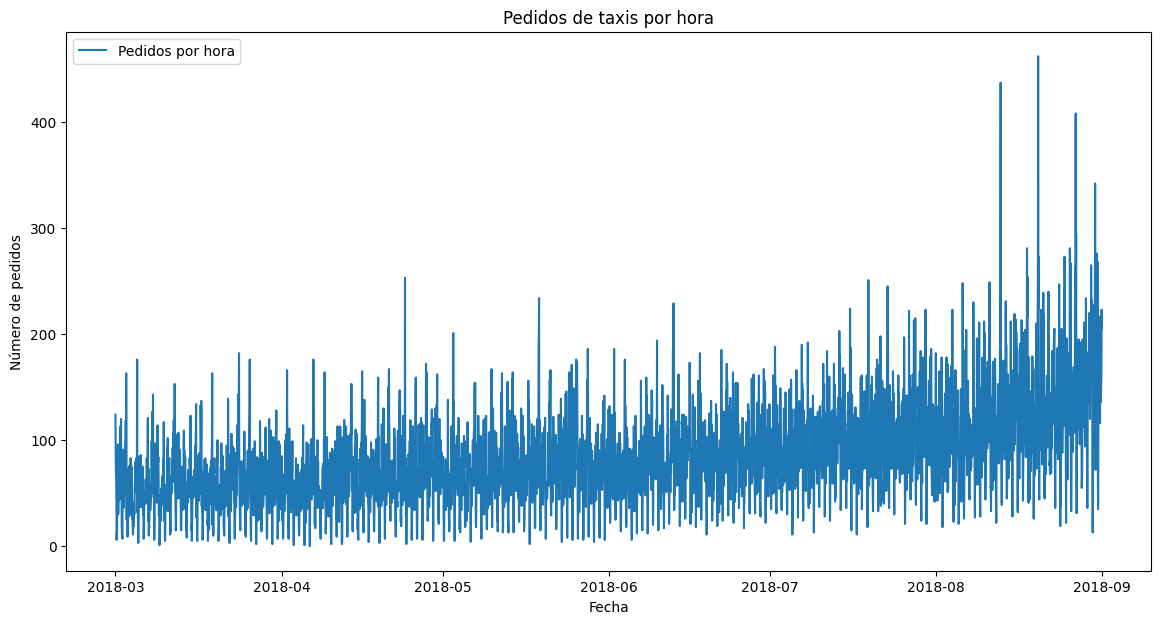

In [5]:
# Visualizar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(data_hourly.index, data_hourly['num_orders'], label='Pedidos por hora')
plt.title('Pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

Es posible observar una tendencia creciente en la demanda así como incrementos más notorios en ciertos meses. Destaca que los principales aumentos en la demanda ocurren durante los meses de julio en adelante, lo cual podría asociarse con la temporada alta por verano. 

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a> Has visualizado correctamente la serie temporal, mostrando una clara tendencia en los datos. Sería útil realizar un análisis más profundo de la estacionalidad y tendencia utilizando descomposición de series temporales, ya que esto podría revelar factores clave que podrían influir en la predicción de la demanda. </div>

## Formación

In [6]:
# Convertir el índice de tiempo a un número total de horas desde el inicio de la serie temporal
data_hourly['hour_since_start'] = (data_hourly.index - data_hourly.index[0]).total_seconds() / 3600

In [7]:
# Definir el tamaño del conjunto de entrenamiento como el 90% del total
train_size = int(len(data_hourly) * 0.9)

In [8]:
# División de datos en entrenamiento y prueba usando la columna numérica
train_data = data_hourly[:train_size]
test_data = data_hourly[train_size:]

In [9]:
# Extraer la característica de la hora desde el inicio
X_train = train_data[['hour_since_start']]
y_train = train_data['num_orders']
X_test = test_data[['hour_since_start']]
y_test = test_data['num_orders']

In [10]:
# Modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
print(f'RECM para Regresión Lineal: {linear_rmse}')

RECM para Regresión Lineal: 64.3602059567073


In [112]:
# Hiperparámetros para Random Forest
rf_params = {
    'n_estimators': [250, 500],  
    'max_depth': [5, 10], 
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2],
}

# Entrenar el modelo Random Forest
random_search_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                                      param_distributions=rf_params, 
                                      random_state=42)
random_search_rf.fit(X_train, y_train)

best_rf_model = random_search_rf.best_estimator_
rf_preds = best_rf_model.predict(X_test)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print(f'Mejor RECM para Random Forest: {best_rf_rmse}')
print("Mejores hiperparámetros:", random_search_rf.best_params_)

Mejor RECM para Random Forest: 61.78212569025143
Mejores hiperparámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}


In [ ]:
# Hiperparámetros para LightGBM
lgb_params = {
    'n_estimators': [250, 500],
    'num_leaves': [5, 10],
    'max_depth': [10, 25],
    'min_data_in_leaf': [1, 2],
    'feature_fraction': [0.5, 0.9],
    'learning_rate': [0.05, 0.01],
}

lgb_model = lgb.LGBMRegressor(random_state=42)

random_search_lgb = RandomizedSearchCV(lgb_model,
                                       param_distributions=lgb_params,
                                       random_state=42)

# Ajustar el modelo
random_search_lgb.fit(X_train, y_train)

# Predecir y evaluar
best_lgb_model = random_search_lgb.best_estimator_
lgb_preds = best_lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_preds))

# Imprimir resultados
print(f'Mejor RECM para LightGBM: {lgb_rmse}')
print("Mejores hiperparámetros:", random_search_lgb.best_params_)

Es posible observar que el modelo Random Forest tiene un desempeño ligeramente mejor que el modelo de Regresión Lineal en la predicción de la cantidad de pedidos de taxis. Sin embargo, destaca que el modelo LigthGBM tiene mejor RECM que ambos.  

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a> La división de los datos y el uso de regresión lineal como modelo inicial es un buen punto de partida. El enfoque en ajustar los hiperparámetros de Random Forest y LightGBM también es positivo. Sin embargo, sería valioso probar validación cruzada (cross-validation) en lugar de una simple división para garantizar la estabilidad del modelo. También podrías explorar modelos más avanzados de series temporales como ARIMA o Prophet. </div>

## Prueba

In [ ]:
# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['num_orders'], label='Valores Reales', color='blue')
plt.plot(test_data.index, rf_preds, label='Predicciones', color='red')
plt.title('Predicción de pedidos de taxis')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

Las predicciones muestran constancia en la cantidad de taxis que se requieren.

## Conclusión

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a> La conclusión es clara al identificar que el modelo LightGBM tuvo el mejor desempeño. Sería recomendable incluir recomendaciones sobre cómo el modelo puede ser optimizado aún más.. </div>







Es posible observar que el modelo LigthGBM fue el que obtuvo un mejor RECM para la predicción de la cantidad de pedidos de r

<div class="alert alert-block alert-success">    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Qué gran trabajo has hecho!  &#128077;  Podemos aprobar el proyecto. <br>
Has demostrado un excelente conocimiento en la construcción de modelos, al eliminar variables innecesaria <br>
<br>Quiero felicitarte por un trabajo excepcional y por la calidad de tu análisis. Te animo a que sigas aprendiendo y desafiando tu potencial en los próximos sprints. Estoy seguro de que tus habilidades y conocimientos serán valiosos en el futuro y te permitirán abordar problemas cada vez más complejos con éxito.
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48